In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import json
import io
import time
import re
import sys
from pyspark import SparkConf, SparkContext
import findspark
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
def train_test_split(n = 0.7):
    time1 = time.time()
    # import files
    review_json_file = '/Users/wenxianfei/Desktop/lda_cf/review.json'

    review = []
    for line in open(review_json_file, 'r'):
        review.append(json.loads(line))

    # convert to dataframe
    review_df = pd.DataFrame.from_records(review)
    # extract the userful column
    review_df = review_df.loc[:,['business_id','user_id','stars','text']]
    # split the test and training dataset
    length = int(len(review_df) * n)

    review_df_training = review_df.iloc[:length,]
    review_df_test = review_df.iloc[length:,]
    review_df_training.to_csv('training.csv')
    review_df_test.to_csv('test.csv')
    time2 = time.time()
    print('SUCCESS!!!  train_test_split')
    print('The training set has ', length, 'rows data')
    print('The testing set has ', len(review_df) - length, 'rows data')
    print('Time: ', time2 - time1)

In [3]:
def textProcessing(text):
    # lower words  
    text = text.lower()
    # remove punctuation
    for c in string.punctuation:
        text = text.replace(c, ' ')
    # tokenize
    wordLst = nltk.word_tokenize(text)
    # stop word
    filtered = [w for w in wordLst if w not in stopwords.words('english')]
    # keep noun  
    refiltered =nltk.pos_tag(filtered)
    filtered = [w for w, pos in refiltered if pos.startswith('NN')]
    # xtract the stem
    ps = PorterStemmer()
    filtered = [ps.stem(w) for w in filtered]

    return " ".join(filtered) 

def rating_proportion(text,rate):
    return text * int(rate)

In [4]:
def lda(review,n_topic = 10,n_top_words=20):
# vectorization
# generate the word-docu matrix
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')
    tf = tf_vectorizer.fit_transform(review)
# train the lda model
    lda = LatentDirichletAllocation(n_topics=n_topic, 
                                max_iter=50,
                                learning_method='batch')
    lda.fit(tf)
# print the performance
    print('perplexity is: ',lda.perplexity(tf))

# generate the top word list for every topic
    tf_feature_names = tf_vectorizer.get_feature_names()
    feature_dict = {k: v for v, k in enumerate(tf_feature_names)}

#     for topic_idx, topic in enumerate(lda.components_):       
#         print ("Topic #%d:" % topic_idx)
#         print (" ".join([tf_feature_names[i]
#                         for i in topic.argsort()[:-n_top_words - 1:-1]]))    

# return the topic*word distribution matrix
    return lda.components_,feature_dict,lda.perplexity(tf)

In [5]:
train_test_split(n = 0.0001)

SUCCESS!!!  train_test_split
The training set has  668 rows data
The testing set has  6685232 rows data
Time:  233.52721118927002


In [6]:
training = pd.read_csv('training.csv')

In [7]:
training.head()

,Unnamed: 0,business_id,user_id,stars,text
0,0,ujmEBvifdJM6h6RLv4wQIg,hG7b0MtEbXx5QzbzE6C_VA,1.0,Total bill for this horrible service? Over $8G...
1,1,NZnhc2sEQy3RmzKTZnqtwQ,yXQM5uF2jS6es16SJzNHfg,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,2,WTqjgwHlXbSFevF32_DJVw,n6-Gk65cPZL6Uz8qRm3NYw,5.0,I have to say that this office really has it t...
3,3,ikCg8xy5JIg_NGPx-MSIDA,dacAIZ6fTM6mqwW5uxkskg,5.0,Went in for a lunch. Steak sandwich was delici...
4,4,b1b1eb3uo-w561D0ZfCEiQ,ssoyf2_x0EQMed6fgHeMyQ,1.0,Today was my second out of three sessions I ha...


In [8]:
training['text'] = training['text'].apply(textProcessing)

In [9]:
training['text'] = training['text'] * training['stars'].apply(int)

In [10]:
review_by_user = training.groupby('user_id').text.sum()
review_by_business = training.groupby('business_id').text.sum()

In [11]:
review_by_user.to_csv('review_by_user.csv')
review_by_business.to_csv('review_by_business')

/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  458.6541128749768


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  439.17738654328883


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  431.33756469103423


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  423.61697259320766


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  418.3606444038477


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  413.5230082864388


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  397.09854202640526


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  392.16586987954497


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  391.08646211965197


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  383.94512948031945


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  375.25015198453445


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  368.4343408387418


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  363.22821035433196


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  357.037645026971


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  360.5861538061047


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  355.6367249890789


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  344.07308178987006


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  346.61696990531


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  332.9097265057555


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  340.52215337357336


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  340.45617475461904


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  330.4628605310569


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  327.7083620342992


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  330.15632191388204


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  321.2653540651238


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  315.4179526309332


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  318.01274477351205


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  315.0502051322014


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  312.44002401303214


/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


perplexity is:  315.8580269667757


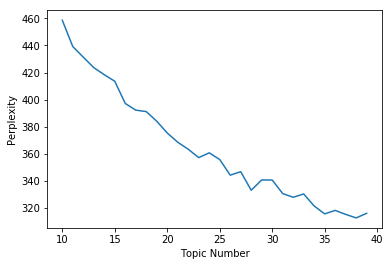

AttributeError: 'numpy.float64' object has no attribute 'index'

In [12]:
review = training['text'] 
topic_word_matrix_set = []
feature_dict_set = []
perplexity_set = []
# lda_set = []
for i in range(10,40):
    topic_word_matrix,feature_dict,perplexity = lda(review,n_topic=i,n_top_words=20)
    topic_word_matrix_set.append(topic_word_matrix)
    feature_dict_set.append(feature_dict)
    perplexity_set.append(perplexity)
#     lda_set.append(lda)

plt.xlabel("Topic Number")
plt.ylabel("Perplexity")
plt.plot([i for i in range(10,40)],perplexity_set)
plt.show()

best_num_topic = perplexity.index(min(perplexity_set))
feature_dict = feature_dict_set[best_num_topic]
topic_word_matrix = topic_word_matrix_set[best_num_topic]
# lda = lda_set[best_num_topic]

# for topic_idx, topic in enumerate(lda.components_):       
#     print ("Topic #%d:" % topic_idx)
#     print (" ".join([tf_feature_names[i]
#                     for i in topic.argsort()[:-n_top_words - 1:-1]])) 

In [13]:
def topic_probability(document,feature_dict,topic_word_matrix):
    word_list = document.split()
    topic_num = len(topic_word_matrix)
    topic_probability = {k:0 for k in range(topic_num)}
    for topic_idx in range(topic_num):
        for word in word_list:
            if word in feature_dict.keys():
                topic_probability[topic_idx] += topic_word_matrix[topic_idx,feature_dict[word]]
    return topic_probability

In [14]:
review_by_user = pd.read_csv('review_by_user.csv',header=None)
review_by_business  = pd.read_csv('review_by_business',header=None)

In [15]:
review_by_user[2] = review_by_user[1].apply(lambda x: topic_probability(x,feature_dict,topic_word_matrix))
review_by_business[2] = review_by_business[1].apply(lambda x: topic_probability(x,feature_dict,topic_word_matrix))

In [16]:
import math
def normalize(x):
    normalized_list = []
    new_dict = {}
    for key,value in x.items():
        normalized_list.append(value**2)
    for key,value in x.items():
        new_dict[key] = value/math.sqrt(sum(normalized_list))
    return new_dict

In [17]:
review_by_user[2] = review_by_user[2].apply(normalize)
review_by_business[2] = review_by_business[2].apply(normalize)

In [18]:
review_by_business

,0,1,2
0,-1xuC540Nycht_iWFeJ-dw,trè bon poulet avec la sauc piquant c succul b...,"{0: 0.006722492664553605, 1: 0.070772705921007..."
1,-4TMQnQJW1yd6NqGRDvAeA,fan mission place owner surpris other ambianc ...,"{0: 0.030066576567209968, 1: 0.138832858796007..."
2,-DHKF52ALa4B2ls1V6OlxA,vision sourc hill opinion appoint strain staff...,"{0: 0.05496510832390817, 1: 0.0739947197826534..."
3,-RwnEdrn3ZdW1yug_CBmLg,shaunz shirt staff qualiti cloth select shaunz...,"{0: 0.0004430632554535706, 1: 0.01382071509753..."
4,-U7tvCtaraTQ9b0zBhpBMA,bacon guy bacon borderlin crispi salti salti c...,"{0: 0.08073467794010622, 1: 0.1325318402499731..."
5,-iFvYhgysvjkxckCr42NRw,servic food place expect place food time day t...,"{0: 0.04001963797584032, 1: 0.1717099443643942..."
6,-oOKqZbYDt08zaWWyLZNIw,food price amount food payfood price amount fo...,"{0: 0.00333498985835133, 1: 0.1387851909542562..."
7,01o6K5ID_vW8tXZ7QAzPJg,prc tile roof replac commun area prc caught nu...,"{0: 0.04996315201751073, 1: 0.1234971226182015..."
8,0BW6h-igJinzbqc-prYUaQ,hy steakhous steak hous lot space intim experi...,"{0: 0.017464753522664404, 1: 0.154617987601358..."
9,0JGMKaKJGVuDus5WcJzvjw,experi start reserv saturday drink drink order...,"{0: 0.010736825519326334, 1: 0.172386834992390..."


In [19]:
user_business = {}
for i in range(len(review_by_user)):
    for j in range(len(review_by_business)):
        user_rating = review_by_user.iloc[i,2]
        business_rating = review_by_business.iloc[j,2]
        rating = 0
        for k in range(len(user_rating)):
            rating += user_rating[k]*business_rating[k]
        user_business[(review_by_user.iloc[i,0],review_by_business.iloc[j,0])] = rating

    

In [20]:
user_business

{('-00MbjbaOISrcuV7jOVRIg', '-1xuC540Nycht_iWFeJ-dw'): 0.49675864859435503,
 ('-00MbjbaOISrcuV7jOVRIg', '-4TMQnQJW1yd6NqGRDvAeA'): 0.6196619433155379,
 ('-00MbjbaOISrcuV7jOVRIg', '-DHKF52ALa4B2ls1V6OlxA'): 0.5366543133158065,
 ('-00MbjbaOISrcuV7jOVRIg', '-RwnEdrn3ZdW1yug_CBmLg'): 0.2248417714489372,
 ('-00MbjbaOISrcuV7jOVRIg', '-U7tvCtaraTQ9b0zBhpBMA'): 0.5482547857714138,
 ('-00MbjbaOISrcuV7jOVRIg', '-iFvYhgysvjkxckCr42NRw'): 0.7556916185821648,
 ('-00MbjbaOISrcuV7jOVRIg', '-oOKqZbYDt08zaWWyLZNIw'): 0.5789522619092374,
 ('-00MbjbaOISrcuV7jOVRIg', '01o6K5ID_vW8tXZ7QAzPJg'): 0.4490232617855071,
 ('-00MbjbaOISrcuV7jOVRIg', '0BW6h-igJinzbqc-prYUaQ'): 0.7756373772195898,
 ('-00MbjbaOISrcuV7jOVRIg', '0JGMKaKJGVuDus5WcJzvjw'): 0.7582560072203874,
 ('-00MbjbaOISrcuV7jOVRIg', '0Yeb_P24sj6MwG2qmuehkA'): 0.6065974403005728,
 ('-00MbjbaOISrcuV7jOVRIg', '0aPaRrZp7iH0PiYnXoa1NQ'): 0.25616025229897826,
 ('-00MbjbaOISrcuV7jOVRIg', '0qSKZhVC_BHPuKro4QGWJw'): 0.6394861533420241,
 ('-00MbjbaOISrcuV7jOVR